Data Processing and Separation
==============================

In [109]:
!pip install librosa

In [110]:
import pandas as pd
import numpy as np
import librosa as lib
import IPython.display as ipd
import matplotlib.pyplot as plt

In [111]:
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "/dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]

testSet = valid_data.sample(n=100, random_state=100)
testSet.to_csv("../test_set.csv")

trainingSet = valid_data.drop(testSet.index)
trainingSet.to_csv("../training_set.csv")

In [112]:
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "../dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]
processingSet

,affect,file_path,phone_position
0,sadness,../dataset/shout_data_3afd7208-7987-4c73-8e01-...,Place phone on the opposite side of the room i...
1,neutral,../dataset/shout_data_ae6feb35-cf7a-4805-8d05-...,Hold your phone next to your face but with the...
2,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...
3,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...
4,disgust,../dataset/shout_data_739dbf1c-ec21-42db-9e49-...,Place phone 1-2 meters away face up on any sur...
...,...,...,...
3048,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3049,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3050,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3051,fear,../dataset/shout_data_d5d4e179-d411-4652-b80b-...,Place phone 1-2 meters away face down on a har...


Time Domain Feature Extraction
===================
https://www.youtube.com/watch?v=SRrQ_v-OOSg

https://www.youtube.com/watch?v=rlypsap6Wow

https://www.youtube.com/watch?v=EycaSbIRx-0

Time-domain features:
- Amplitude envelope 
- Root-mean-square energy 
- Zero-crossing rate

In [113]:
FRAME_SIZE = 512 # the size of the frame
HOP_LENGTH = 256 # the distance each frame jumps by
FRAME_LENGTH = 512 # length of a frame

def getFeatures(audioSignal, sample_rate, maxAudioLength):
    audioFile = lib.util.pad_center(audioSignal, size=maxAudioLength)
    
    # duration of 1 sample
    oneSampleDuration = 1/sample_rate
    
    # duration of audio signal in seconds
    sampleDuration = oneSampleDuration*len(audioFile)
    
    ae, time = getAmplitudeEnvelope(audioFile)
    rms = getRMS(audioFile)
    zcr = getZCR(audioFile)
    
    return time, ae, rms, zcr
    
def getAmplitudeEnvelope(audioSignal):
    amplitudeEnvelope = []
    
    for i in range(0, len(audioSignal), HOP_LENGTH):
        currentFrameAE = max(audioSignal[i:i+FRAME_SIZE])
        amplitudeEnvelope.append(currentFrameAE)
        
    amplitudeEnvelope = np.array(amplitudeEnvelope)
    amplitudeFrames = range(0, amplitudeEnvelope.size)
    time = lib.frames_to_time(amplitudeFrames, hop_length=HOP_LENGTH)
    
    return amplitudeEnvelope, time
    
def getRMS(audioSignal):
    rms = []
    for i in range(0, len(audioSignal), HOP_LENGTH):
        rms_current = np.sqrt(np.sum(audioSignal[i:i+FRAME_LENGTH]**2) / FRAME_LENGTH)
        rms.append(rms_current)
    return rms

def getZCR(audioSignal):
    return lib.feature.zero_crossing_rate(audioSignal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]


In [114]:
ipd.Audio(processingSet["file_path"][0])

audio clip duration: 3.6560090702947847
audio envelope length: 315
RMSE length: 315
ZCR length: 315


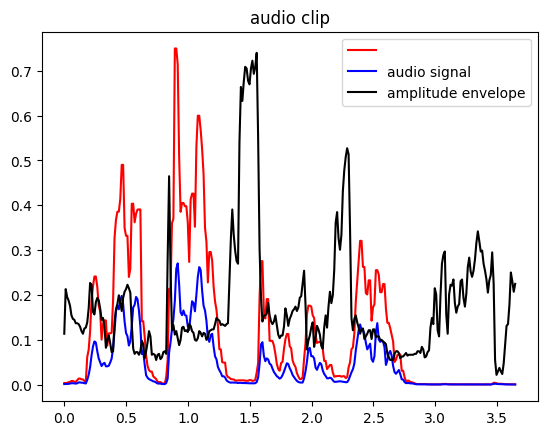

In [115]:
audioFile, sample_rate = lib.load(processingSet["file_path"][1002])

audioClipDuration = len(audioFile) / sample_rate

print("audio clip duration: {}".format(audioClipDuration))

(ae_audio, time) = getAmplitudeEnvelope(audioFile)
print("audio envelope length: {}".format(len(ae_audio)))

rms_audio = getRMS(audioFile)
print("RMSE length: {}".format(len(rms_audio)))

zcr_audio = getZCR(audioFile)
print("ZCR length: {}".format(len(zcr_audio)))

lib.display.waveshow(audioFile, alpha = 0.5)
plt.title("Time domain Features (Clip 1002): Fear")
plt.plot(time, ae_audio, color="r")
plt.plot(time, rms_audio, color = 'b')
plt.plot(time, zcr_audio, color = 'k')
plt.ylabel("Amplitude")

plt.legend(["", "audio signal", "amplitude envelope", "Root Mean Squared Energy", "Zero Crossing Rate"])
# 1002

Frequency Domain Feature Extraction
=========
https://www.youtube.com/watch?v=3-bjAoAxQ9o

https://www.youtube.com/watch?v=8UJ8ZDR7yUs

https://www.youtube.com/watch?v=j6NTatoi928

Time-domain features:
- Spectral Centroid
- Bandwidth
- Band Energy Ratio

In [116]:
def calc_sfb(spec, freq, sr):
    freq_range = sr/2
    freq_delta = freq_range / spec.shape[0]
    return int(np.floor(freq / freq_delta))

In [117]:
def calc_ber(spec, freq, sr):
    sfb = calc_sfb(spec, freq, sr)
    pSpec = np.abs(spec) ** 2
    pSpec = pSpec.T
    ber = []

    for freqs in pSpec:
        sum_low = np.sum(freqs[:sfb])
        sum_high = np.sum(freqs[sfb:])
        ber_current = sum_low/sum_high
        ber.append(ber_current)

    return np.array(ber)

In [118]:
def getFrequencyFeatures(audioSignal, sample_rate):
    audio_spec = lib.stft(audioFile, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    centroid = lib.feature.spectral_centroid(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    bandwidth = lib.feature.spectral_bandwidth(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    ber = calc_ber(audio_spec, 2000, sample_rate)
    return centroid, bandwidth, ber

fear


(0.0, 8000.0)

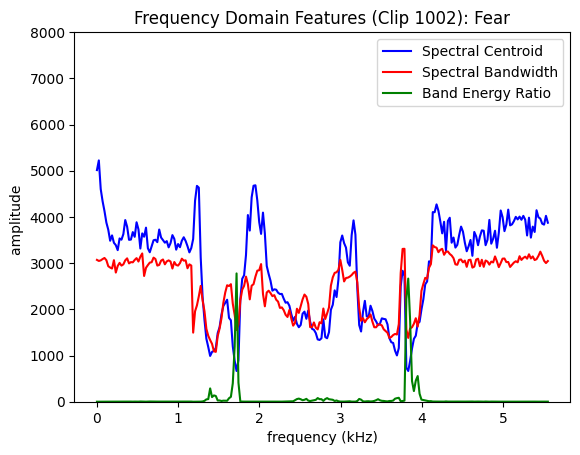

In [173]:
clipNumber = 1002
audioFile, sample_rate = lib.load(processingSet["file_path"][clipNumber])
print(processingSet["affect"][clipNumber])
audio_spec = lib.stft(audioFile, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
centroid = lib.feature.spectral_centroid(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
bandwidth = lib.feature.spectral_bandwidth(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
ber = calc_ber(audio_spec, 2000, sample_rate)
frames = range(len(centroid))
# plt.figure(figsize=(10, 7))
plt.title("Frequency Domain Features (Clip 1002): {}".format(processingSet["affect"][clipNumber].capitalize()))
plt.plot(lib.frames_to_time(frames), centroid, color='b')
plt.plot(lib.frames_to_time(frames), bandwidth, color='r')
plt.plot(lib.frames_to_time(frames), ber, color='g')
plt.legend(["Spectral Centroid", "Spectral Bandwidth", "Band Energy Ratio"])
plt.xlabel("frequency (kHz)")
plt.ylabel("amplitude ")
plt.ylim(0, 8000)

In [121]:
# audio processing and getting features
zeroCrossingRateList = []
amplitudeEnvelopeList = []
rootMeanSquareEnergyList = []
spectralCentroidList = []
spectralBandwidthList = []
bandEnergyRatioList = []
timings = []
audioFileLengths = []

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    audioFileLengths.append(len(audioFile))

maxAudioLength = max(audioFileLengths)    

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    time, ae, rmse, zcr = getFeatures(audioFile, sample_rate, maxAudioLength)
    centroid, bandwidth, ber = getFrequencyFeatures(audioFile, sample_rate)
    zeroCrossingRateList.append(zcr)
    amplitudeEnvelopeList.append(ae)
    rootMeanSquareEnergyList.append(rmse)
    spectralCentroidList.append(centroid)
    spectralBandwidthList.append(bandwidth)
    bandEnergyRatioList.append(ber)
    timings.append(time)
    
processingSet["Timings"] = timings
processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
processingSet["Root_Mean_Square_Energy"] = rootMeanSquareEnergyList
processingSet["Zero-Crossing Rate"] = zeroCrossingRateList
processingSet["Spectral Centroid"] = spectralCentroidList
processingSet["Spectral Bandwidth"] = spectralBandwidthList
processingSet["Band Energy Ratio"] = bandEnergyRatioList

processingSet

KeyboardInterrupt: 

In [ ]:
len(processingSet["Amplitude_Envelope"][0]) == len(processingSet["Amplitude_Envelope"][1000])

True

Frequency Domain Feature Extraction
=========

In [ ]:
trainingSetProcessed = processingSet.drop(testSet.index)
testSetProcessed = processingSet.drop(trainingSetProcessed.index)

trainingSetProcessed.to_csv("../training_set_processed.csv")
testSetProcessed.to_csv("../test_set_processed.csv")